In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install --upgrade urllib3
!pip install py7zr  #use to compress the model for download

In [ ]:
from datasets import load_dataset
dataset=load_dataset('ccdv/cnn_dailymail', '3.0.0')

In [ ]:
dataset


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 287113
})

In [ ]:
dataset['train']['article'][0][:200]

In [ ]:
dataset['train']['highlights'][0]

'Syrian official: Obama climbed to the top of the tree, "doesn\'t know how to get down"\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .'

In [2]:
from transformers import pipeline


# Let's first check the performance of the different summarization models without fine tuning.


In [ ]:
# using gpt2-medium model due to gpu limitation.
pipe=pipeline("text-generation",model='gpt2-medium')

In [ ]:
#text summarization
input=dataset['train'][1]['article'][:2000]

In [ ]:
query=input+"\nTL;DR:\n"   #\nTL;DR:\n command is used to generate the summary in gpt2 model as mentioned in the paper
output=pipe(query,max_length=700,clean_up_tokenization_spaces=True)

In [ ]:
output

In [ ]:
output[0]['generated_text']

In [ ]:
output[0]['generated_text'][len(query):]

In [ ]:
summaries={}
summaries['gpt2-medium-380M']=output[0]['generated_text'][len(query):]

In [ ]:
# T5 base model with 233M parameters: Transformer based

In [ ]:
pipe=pipeline("summarization",model='t5-base')

In [ ]:
output=pipe(input)

In [ ]:
output[0]

In [ ]:
output[0]['summary_text']

In [ ]:
summaries['t5-base-233M']=output[0]['summary_text']

In [ ]:
#BART :bart-large fine tuned over cnn data
#pipe=pipeline('summarization',model='facebook/bart-large-cnn')
#output=pipe(input)

In [ ]:
output[0]

{'summary_text': 'usain bolt wins third gold medal at world championships . anchors Jamaica to victory in 4x100m relay . anchored by shelly-Ann Fraser-Pryce who completes triple . world champions the united states finish second .'}

In [ ]:
#summaries['facebook/bart-large-cnn']=output[0]['summary_text']

In [ ]:
#pegasus-cnn_daily
#pipe=pipeline('summarization',model='google/pegasus-cnn_dailymail')
#output=pipe(input)

In [ ]:
#output[0]

In [ ]:
#summaries['google/pegasus-cnn_dailymail-568M']=output[0]['summary_text']

In [ ]:
for model in summaries:
  print(model.upper())
  print(summaries[model])
  print(" ")

GPT2-MEDIUM-380M
The Jamaican relay team's record to finish as the best individual race in history. The U.S' third world championship win has lifted them above France
Posted by T-Money at 8:45 PM
 
T5-BASE-233M
usain bolt wins third gold medal at world championships . anchors Jamaica to victory in 4x100m relay . anchored by shelly-Ann Fraser-Pryce who completes triple . world champions the united states finish second .
 


# Fine tuning the 'facebook/bart-large-cnn' model using samsum dataset

In [ ]:
!pip install -U datasets

In [3]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM,AutoTokenizer
import torch

In [ ]:
device='gpu'
model_ckpt='facebook/bart-large-cnn' #for model checkpoint
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)
model=AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

In [ ]:
samsum=load_dataset('samsum')

In [5]:
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [6]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [6]:
dialogue_len=[len(x['dialogue'].split()) for x in samsum['train']]
summary_len=[len(x['summary'].split()) for x in samsum['train']]

In [7]:
import pandas as pd

df=pd.DataFrame([dialogue_len,summary_len]).T
df.columns=["dialogue_len","summary_len"]
df

,dialogue_len,summary_len
0,16,9
1,18,10
2,98,14
3,26,18
4,179,27
...,...,...
14727,56,16
14728,198,36
14729,142,22
14730,276,40


array([[<Axes: title={'center': 'dialogue_len'}>,
        <Axes: title={'center': 'summary_len'}>]], dtype=object)

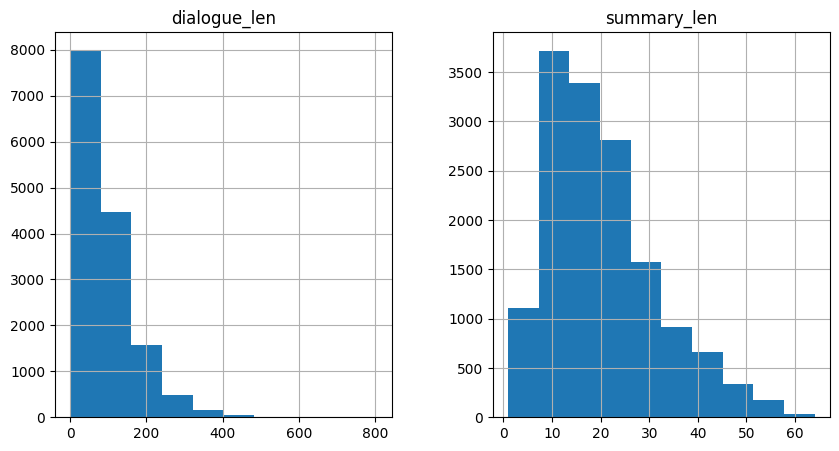

In [9]:
df.hist(figsize=(10,5))

In [8]:
# Let's build the data collator

def get_feature(batch):
  encoding=tokenizer(batch['dialogue'],text_target=batch['summary'],
                     max_length=1024,truncation=True)

  encoding={'input_ids':encoding['input_ids'],
            'attention_mask':encoding['attention_mask'],
            'labels':encoding['labels']}
  return encoding

In [11]:
samsum_pt=samsum.map(get_feature,batched=True) #pt for pytorch

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [12]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [13]:
columns=['input_ids','attention_mask','labels']
samsum_pt.set_format(type='torch',columns=columns)

In [ ]:
! pip install rouge_score

In [ ]:
! pip install evaluate

In [22]:
import evaluate
rouge = evaluate.load('rouge')

In [23]:
from datasets import load_metric

#rouge_metric = load_metric("rouge")
rouge_metric = evaluate.load('rouge')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute the Rouge score using the Rouge metric
    rouge_output = rouge_metric.compute(predictions=predictions, references=labels, use_stemmer=True)
    return rouge_output

In [24]:
from transformers import DataCollatorForSeq2Seq
data_collator=DataCollatorForSeq2Seq(tokenizer,model=model)


In [16]:
from transformers import TrainingArguments, Trainer


training_args=TrainingArguments(
    output_dir='finetunedN-facebook-bart-samsum',
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    metric_for_best_model='eval_loss',
    eval_steps=500,
    gradient_accumulation_steps=16,
    push_to_hub=True,
    push_to_hub_model_id='finetunedN-facebook-bart-samsum',
    push_to_hub_organization="codebasics",
    push_to_hub_token="hf_ltknSULNroXjMrgBWlSOOpvHWPnADrcD", #replace with original
    report_to="tensorboard",  # or "wandb" for Weights & Biases
)

# Initialize the Trainer object with the updated TrainingArguments
trainer=Trainer(model=model,
                args=training_args,
                tokenizer=tokenizer,
                data_collator=data_collator,
                train_dataset=samsum_pt['train'],
                eval_dataset=samsum_pt['validation'],
                compute_metrics=compute_metrics
                )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1847: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1859: FutureWarning: `--push_to_hub_model_id` and `--push_to_hub_organization` are deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case codebasics/finetunedN-facebook-bart-samsum).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches

In [17]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=460, training_loss=1.4280137269393258, metrics={'train_runtime': 1704.9003, 'train_samples_per_second': 8.641, 'train_steps_per_second': 0.27, 'total_flos': 6795714120007680.0, 'train_loss': 1.4280137269393258, 'epoch': 1.0})

In [33]:
# Evaluating model performance on the tokenized validation dataset
#validation = trainer.evaluate(eval_dataset = samsum_pt['validation'])
#print(validation) # Coudn't do due to resource problems

# Push to hub from trainer directly

In [18]:
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1712898270.a0cd477ee411.8405.0:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

events.out.tfevents.1712897961.a0cd477ee411.228.2:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/codebasics/finetunedN-facebook-bart-samsum/commit/2e5c2086edc535c995ed6b8666daa0e718a83b82', commit_message='End of training', commit_description='', oid='2e5c2086edc535c995ed6b8666daa0e718a83b82', pr_url=None, pr_revision=None, pr_num=None)

In [3]:
finetuned_model="codebasics/finetunedN-facebook-bart-samsum"
pipe=pipeline("summarization",model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

In [25]:
#original_model='facebook/bart-large-cnn'
finetuned_model="codebasics/finetunedN-facebook-bart-samsum"
tokenizer=AutoTokenizer.from_pretrained(finetuned_model)
finetuned_model=AutoModelForSeq2SeqLM.from_pretrained(finetuned_model,torch_dtype=torch.bfloat16).to('cpu')

tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

In [26]:
model_ckpt='facebook/bart-large-cnn' #for model checkpoint
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)
original_model=AutoModelForSeq2SeqLM.from_pretrained(model_ckpt,torch_dtype=torch.bfloat16).to('cpu')

In [27]:
rouge = evaluate.load('rouge')

In [28]:
from transformers import  GenerationConfig

In [30]:
dialogues = samsum['test'][0:10]['dialogue']
human_baseline_summaries = samsum['test'][0:10]['summary']

original_model_summaries = []
finetuned_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    finetuned_model_outputs = finetuned_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    finetuned_model_text_output = tokenizer.decode(finetuned_model_outputs[0], skip_special_tokens=True)
    finetuned_model_summaries.append(finetuned_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, finetuned_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'finetuned_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,finetuned_model_summaries
0,Hannah needs Betty's number but Amanda doesn't...,. The conversation. The conversation was about...,.
1,Eric and Rob are going to watch a stand-up on ...,,
2,Lenny can't decide which trousers to buy. Bob ...,. The conversation was about buying trousers.,the best quality trousers for Lenny's purple ...
3,Emma will be home soon and she will let Will k...,. The conversation was between two friends.,.
4,Jane is in Warsaw. Ollie and Jane has a party....,". The conversation was between Ollie and Jane,...",. Ollie and Jane will meet for lunch on Friday...
5,Hilary has the keys to the apartment. Benjamin...,. The keys to the apartment were given to Hila...,
6,Payton provides Max with websites selling clot...,,. Max and Payton.
7,Rita and Tina are bored at work and have still...,,.
8,"Beatrice wants to buy Leo a scarf, but he does...",. The conversation took place in a shop in the...,.
9,Eric doesn't know if his parents let him go to...,. The conversation went like this: ...,Eric's brother's wedding. Ivan will take care...


In [35]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

finetuned_model_results = rouge.compute(
    predictions=finetuned_model_summaries,
    references=human_baseline_summaries[0:len(finetuned_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('FINETUNED MODEL:')
print(finetuned_model_results)

ORIGINAL MODEL:
{'rouge1': 0.09234233158146202, 'rouge2': 0.017767332549941246, 'rougeL': 0.07705555695258212, 'rougeLsum': 0.07537430532853874}
FINETUNED MODEL:
{'rouge1': 0.14909090909090908, 'rouge2': 0.061949685534591195, 'rougeL': 0.11515151515151516, 'rougeLsum': 0.11515151515151514}


# Let's check the summaries produced by the fnetuned model

In [34]:
# Customer dialogue prediction


custom_dialogue="""
Sam: Hey hello rachel, how are you?
rachel: good. are you interested in joining this new data science course here?
Sam: what is special about this course?
rachel: prifessor ori is teaching this and he is legend in this area. If want to join just let me know.
Sam: that sounds great. But which topic he is going to cover?
rachel: i thisnk je will teach NLP and LLM.
Sam: Okay, i will join then. thank you for letting me know.
"""



In [7]:
output=pipe(custom_dialogue)


Your max_length is set to 142, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


In [8]:
output

[{'summary_text': 'rachel wants Sam to join her new data science course. Prifessor ori is legend in this area and he is going to teach NLP and LLM topics. Sam will join the course and he will let Rachel know if she wants him to join. '}]

In [9]:
text="""Sam: Hey Harry, have you noticed how everything seems to be getting more expensive lately?

Harry: Yeah, it's crazy. I went grocery shopping yesterday and couldn't believe the prices.

Sam: Exactly! I heard on the news that it's because of inflation. Do you know what that means exactly?

Harry: I think it's when the prices of goods and services increase over time, right?

Sam: Yeah, that's it. It's happening because the value of money is decreasing, so it takes more money to buy the same things.

Harry: So, what can we do about it?

Sam: Well, we can try to budget more carefully and maybe look for cheaper alternatives when possible. But ultimately, it's a complex economic issue.

Harry: Yeah, I guess we'll just have to adapt and hope things get better soon.

Sam: Agreed. Let's keep an eye on it and stay informed."""

In [10]:
output=pipe(text)


In [11]:
output

[{'summary_text': "Everything seems to be getting more expensive lately. Inflation is when the prices of goods and services increase over time. It's happening because the value of money is decreasing, so it takes more money to buy the same things. Harry and Sam will try to budget more carefully and look for cheaper alternatives."}]

In [12]:
text2="""Sam: Hey Harry, I just read an article about investing in stocks to combat inflation.

Harry: Really? How does that work?

Sam: Well, apparently, when inflation goes up, stock prices tend to rise too. So, investing in stocks could potentially help us keep up with the rising cost of living.

Harry: That sounds interesting, but isn't investing in stocks risky?

Sam: It can be, but if we do our research and diversify our investments, it could pay off in the long run.

Harry: Hmm, I'll have to look into it more. Thanks for the tip, Sam.

Sam: No problem, Harry. It's always good to explore different ways to manage our finances, especially with inflation on the rise."""

In [13]:
output=pipe(text2)

In [14]:
output

[{'summary_text': "Sam read an article about investing in stocks to combat inflation. Harry will have to look into it more. It's always good to explore different ways to manage our finances, especially with inflation on the rise, as Sam suggests to Harry.    .  "}]

In [15]:
text3="""Sam: Hey Harry, have you seen the latest advancements in artificial intelligence?

Harry: Yeah, I heard about some pretty cool stuff. Like AI helping doctors diagnose diseases more accurately.

Sam: Exactly! It's amazing how AI is revolutionizing various industries, from healthcare to finance.

Harry: But I also read about concerns regarding AI taking over jobs. Do you think it's something we should worry about?

Sam: It's definitely a valid concern. AI has the potential to automate many tasks, but it also creates new opportunities for innovation and creativity.

Harry: True, but I wonder how AI will impact our daily lives in the future.

Sam: Well, one thing's for sure, AI is here to stay, and it's up to us to adapt and harness its potential for the greater good.

Harry: Absolutely, let's stay curious and keep learning about the exciting possibilities AI brings."""

In [16]:
output=pipe(text3)

In [17]:
output

[{'summary_text': 'Harry and Sam are discussing the latest advancements in artificial intelligence. AI is revolutionizing various industries, from healthcare to finance. There are concerns about AI taking over jobs. AI has the potential to automate many tasks, but it also creates new opportunities for innovation and creativity.'}]